In [3]:
import numpy as np
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from astropy import units as u
from astropy.constants import M_earth, M_sun

from simulate_data import *

import matplotlib 
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)

In [4]:
# orbital parameters from https://www.princeton.edu/~willman/planetary_systems/Sol/
# BJD determined by converting values above using https://ssd.jpl.nasa.gov/tc.cgi#top

P_earth = 365.256
e_earth = 0.0167
Tper_earth= 2454115.5208333
omega_earth = np.radians(102.9)
Omega_earth = np.radians(0.0)
inclination_earth = np.radians(45.0)
m_earth = 1 #units m_earth



P_jup = 4327.631
e_jup = 0.0484
Tper_jup = 2455633.7215278
omega_jup = np.radians(274.3)
Omega_jup = np.radians(100.4)
inclination_jup = np.radians(1.304) + inclination_earth
m_jup = 317.83 #units m_earth


P_nep = 59758.97 
e_nep = 0.00859
Tper_nep = 2468662.5000000
omega_nep = np.radians(273.2)
Omega_nep = np.radians(131.784)
inclination_nep = np.radians(1.7700) + inclination_earth
m_nep = 17.204 #units m_earth5.9724



P_saturn = 10739.58 
e_saturn = 0.0539
Tper_saturn = 2452832.0625000
omega_saturn = np.radians(338.9)
Omega_saturn = np.radians(113.7)
inclination_saturn = np.radians(2.486) + inclination_earth
m_saturn = 95.159 #units m_earth




/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate_data.py:291: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate_data.py:359: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


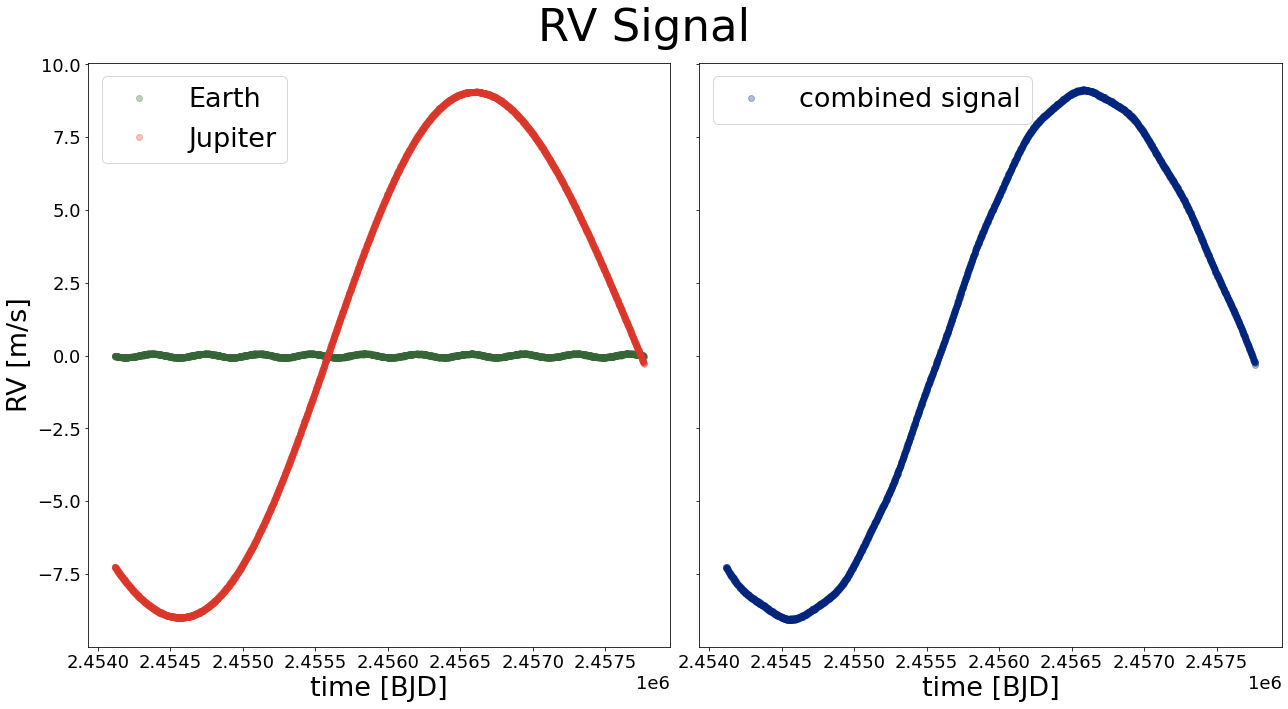

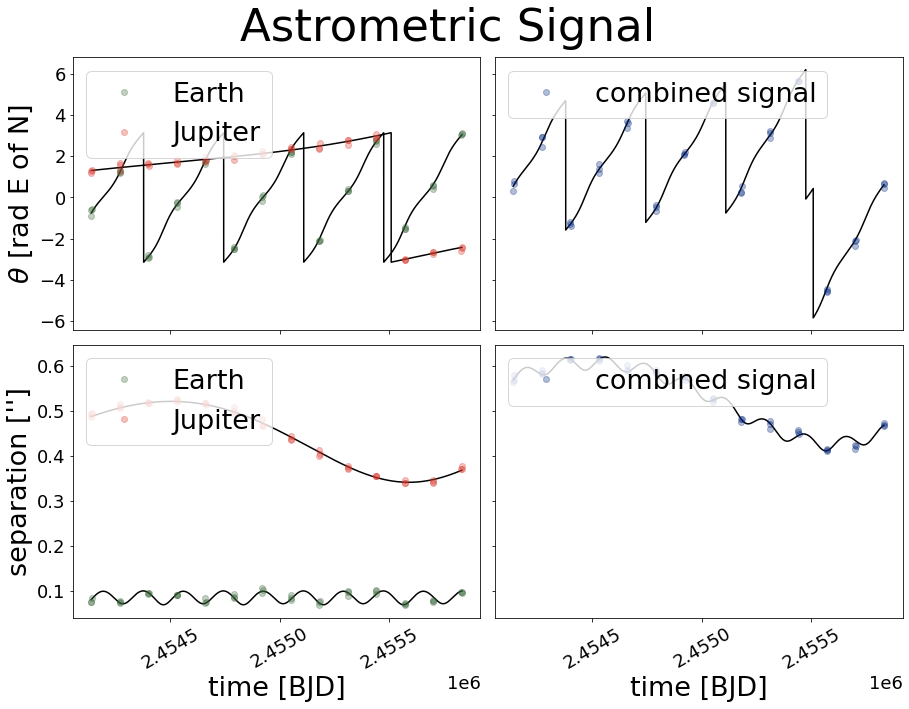

In [13]:
orbit_params_earth = [P_earth, e_earth, Tper_earth, omega_earth, Omega_earth, inclination_earth, m_earth]
orbit_params_jup = [P_jup, e_jup, Tper_jup, omega_jup, Omega_jup, inclination_jup, m_jup]
orbit_params_saturn = [P_saturn, e_saturn, Tper_saturn, omega_saturn, Omega_saturn, inclination_saturn, m_saturn]
orbit_params_nep = [P_nep, e_nep, Tper_nep, omega_nep, Omega_nep, inclination_nep, m_nep]

orbit_params = [orbit_params_earth, orbit_params_jup]

times_observed_astrometry = []
t_0 = int(Tper_earth)
for ii in range(t_0, t_0+1825):
    if ii % 130 == 0:
        times_observed_astrometry.append(ii-1)
        times_observed_astrometry.append(ii)
        times_observed_astrometry.append(ii+1)

n_planets = 2
t_dur_rv = 3650
n_obs_rv = 3000
sigma_rv = 0.01

sigma_theta = 0.1
sigma_rho = 0.005
plx = 0.1


simulate_and_plot(
    n_planets, 
    sigma_rv, 
    sigma_theta,
    sigma_rho,
    plx,
    orbit_params,
    ['#366537', '#db372b', '#00257c'],
    ['Earth', 'Jupiter'],
    t_dur_rv = t_dur_rv,
    n_obs_rv = n_obs_rv,
    times_observed_astrometry = times_observed_astrometry
    )



In [14]:
times, rv_results, theta_results, rho_results = simulate_data(
    n_planets, 
    sigma_rv, 
    sigma_theta,
    sigma_rho,
    plx,
    orbit_params,
    t_dur_rv = t_dur_rv,
    n_obs_rv = n_obs_rv,
    times_observed_astrometry = times_observed_astrometry
    )


[[times_rv, times_observed_rv, times_astrometry, times_observed_astrometry],
     [rv_orbit, rv_orbit_sum, rv_sim, rv_sim_sum],
     [theta_orbit, theta_orbit_sum, theta_sim, theta_sim_sum],
     [rho_orbit, rho_orbit_sum, rho_sim, rho_sim_sum]]  = times, rv_results, theta_results, rho_results

<ErrorbarContainer object of 3 artists>

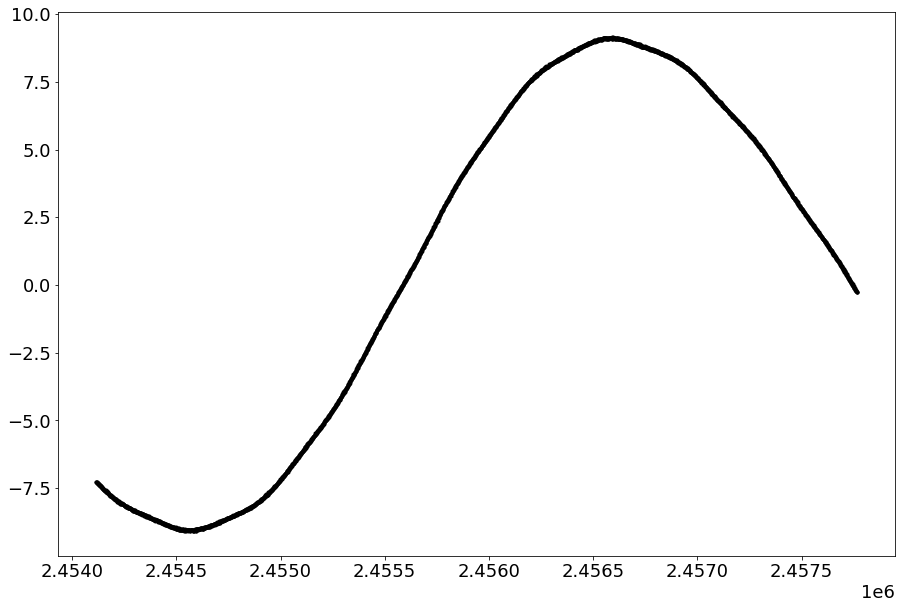

In [16]:
x_rv = times_observed_rv
y_rv = rv_sim_sum
y_rv_err = np.full(np.shape(y_rv), .01)


plt.figure(figsize=[15,10])
plt.errorbar(x_rv,y_rv, yerr=y_rv_err, ls = '', marker = '.', color = 'k')

In [18]:
periods = [365, 4327]
period_errs = [5, 5]
Ks = xo.estimate_semi_amplitude(periods, x_rv, y_rv, y_rv_err)
print(Ks, "m/s")

[0.04929631 9.09218214] m/s


In [21]:
with pm.Model() as model:

    P = pm.Bound(pm.Normal, lower=0)(
        "P",
        mu=np.array(periods),
        sd=np.array(period_errs),
        shape=2,
        testval=np.array(periods),
    )

    # Wide log-normal prior for semi-amplitude
    logK = pm.Bound(pm.Normal, lower=0)(
        "logK", mu=np.log(Ks), sd=10.0, shape=2, testval=np.log(Ks)
    )

    # Eccentricity & argument of periasteron
    ecc = xo.distributions.UnitUniform("ecc", shape=2, testval=np.array([0.1, 0.1]))
    omega = xo.distributions.Angle("omega", shape=2)

    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(y_rv_err)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)


### Now we’ll define the orbit model:



In [23]:
with model:

    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, ecc=ecc, omega=omega)

    # Set up the RV model and save it as a deterministic
    # for plotting purposes later
    vrad = orbit.get_radial_velocity(x_rv, K=tt.exp(logK))
    pm.Deterministic("vrad", vrad)

    # Define the background model
    A = np.vander(x_rv - 0.5 * (x_rv.min() + x_rv.max()), 3)
    bkg = pm.Deterministic("bkg", tt.dot(A, trend))

    # Sum over planets and add the background to get the full model
    rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)

### Now we’ll define the orbit model:



In [26]:
t = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)

with model:
    vrad_pred = orbit.get_radial_velocity(t, K=tt.exp(logK))
    pm.Deterministic("vrad_pred", vrad_pred)
    A_pred = np.vander(t - 0.5 * (x_rv.min() + x_rv.max()), 3)
    bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
    rv_model_pred = pm.Deterministic(
        "rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred
    )

ValueError: Variable name vrad_pred already exists.